# Linear Regression

In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import pandas as pd
from joblib import dump
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression

Now, we proceed as we did in the Superconductivity notebook:

In [2]:
train =  pd.read_parquet('../../../data/model_input/train_sets/house_prices.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/house_prices.parquet')

In [3]:
y_train = train.SalePrice
X_train = train.drop(columns=['SalePrice'])

In [4]:
y_validation = validation.SalePrice
X_validation = validation.drop(columns=['SalePrice'])

In [7]:
scaler = StandardScaler().fit(X_train, y_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [5]:
y_train_scaled = y_train/1000
y_validation_scaled = y_validation/1000

In [19]:
lr = LinearRegression()
lr_l2 = Ridge()
lr_l1 = Lasso()
lr_en1 = ElasticNet(l1_ratio=0.25)
lr_en2 = ElasticNet(l1_ratio=0.5)
lr_en3 = ElasticNet(l1_ratio=0.75)

In [20]:
models_list = [lr, lr_l2, lr_l1, lr_en1, lr_en2 , lr_en3]
names_list = ['LR', 'LR_l2', 'LR_l1', 'LR_en_0.25', 'LR_en_0.5', 'LR_en_0.75']

In [21]:
metrics = regression(models_list, names_list, '../../../data/model_output/metrics/house_prices/linear_regression.csv', X_train_scaled, y_train_scaled, X_validation_scaled, y_validation_scaled)
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LR,0.097415,19.073018,3.077195e+13,1.613376e+14
LR_l2,0.012965,19.085999,3.658210e+01,9.166982e+01
LR_l1,0.023939,21.594144,3.605027e+01,6.694466e+01
LR_en_0.25,0.031912,24.457737,3.598973e+01,4.715068e+01
LR_en_0.5,0.024934,23.571804,3.572529e+01,5.155942e+01
LR_en_0.75,0.023936,22.560388,3.570611e+01,5.826905e+01


Somewhy, the first model is too much overfitted. The rest have similar metrics. Finally, We are left with the **ElasticNet** with l1 ratio = 0.25 as the best model.

Now we go with the next step, that is the final test 

In [6]:
test =  pd.read_parquet('../../../data/model_input/test_sets/house_prices.parquet')

In [7]:
y_test = test.SalePrice
X_test = test.drop(columns=['SalePrice'])

In [8]:
retrain = pd.concat([train, validation])

In [9]:
y_retrain = retrain.SalePrice
X_retrain = retrain.drop(columns=['SalePrice'])

In [10]:
scaler_retrain = StandardScaler().fit(X_retrain, y_retrain)

In [11]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [12]:
y_retrain_scaled = y_retrain/1000
y_test_scaled = y_test/1000

In [34]:
model = ElasticNet(l1_ratio=0.25).fit(X_retrain_scaled, y_retrain_scaled)

In [35]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test_scaled, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 23.6124


Good news, the model upgraded its performance. Let's see the coefficients; as the model has too many variables, let's show only the labels for some features:

In [50]:
top_threshold = 3
top_coefficients = [coef for coef in model.coef_.ravel() if abs(coef) > top_threshold]
top_features = [name for name, coef in zip(X_retrain.columns, model.coef_.ravel()) if abs(coef) > top_threshold]

In [51]:
labels = [' ' if feature not in top_features else feature for feature in X_retrain.columns]

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_16500/606047771.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=60, ha='right')


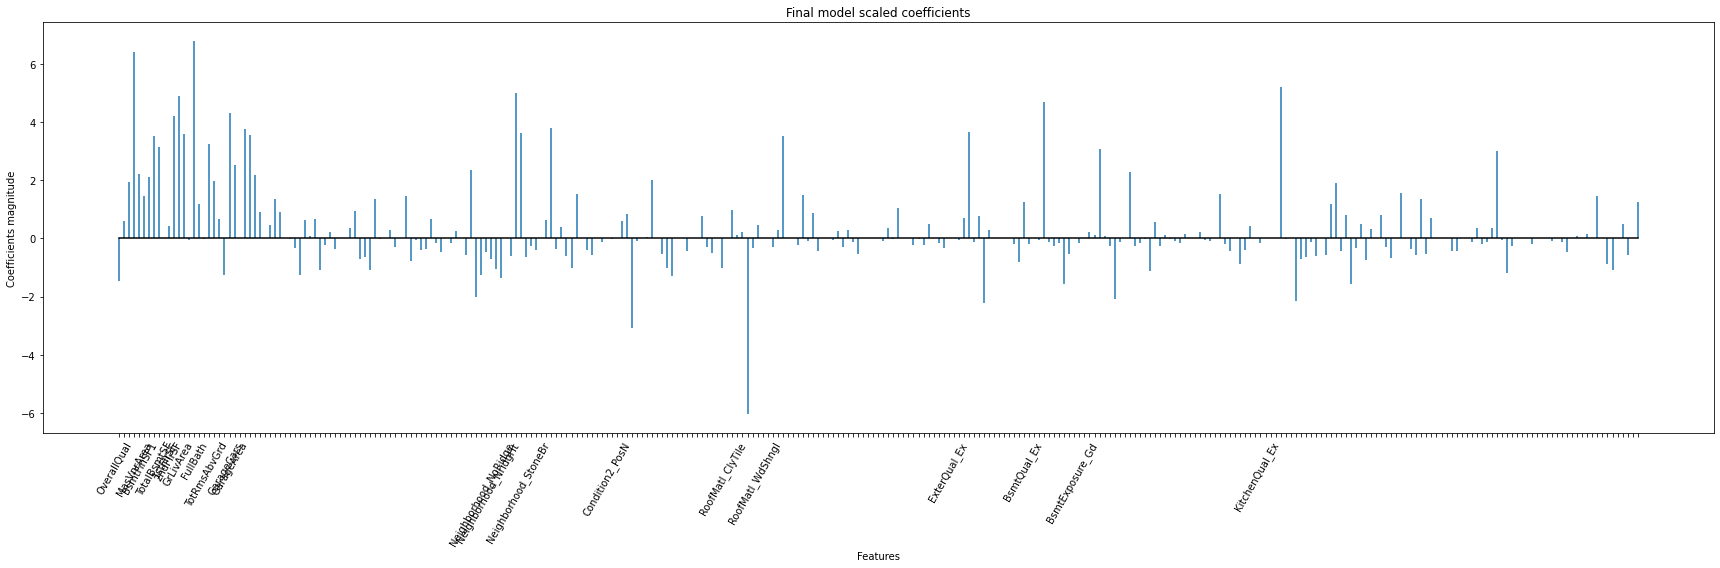

In [60]:
fig, ax = plt.subplots(figsize=(24, 8))
ax.stem(X_retrain.columns, model.coef_.ravel(), markerfmt=' ', basefmt='k-')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Final model scaled coefficients')
ax.set_xticklabels(labels, rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [61]:
dump(model, '../../../data/model_output/models/house_prices/best_linear_regression.joblib')

['best_linear_regression.joblib']

In [62]:
with open('../../../data/model_output/metrics/house_prices/final_RMSE.txt', 'a') as f:
    f.write('\nLR, '+ str(rmse))

## Residuals diagnosis

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_16500/2477425303.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_retrain_scaled.min(), y_retrain_scaled.max()], [y_retrain_scaled.min(), y_retrain_scaled.max()],
C:\aaa\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


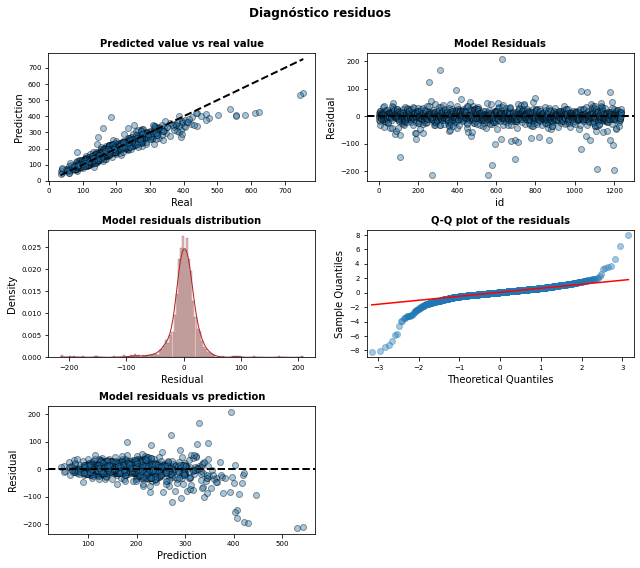

In [63]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain_scaled

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_retrain_scaled, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_retrain_scaled.min(), y_retrain_scaled.max()], [y_retrain_scaled.min(), y_retrain_scaled.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Predicted value vs real value', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Prediction')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_retrain_scaled))), error_retrain,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Model Residuals', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residual')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = error_retrain,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Model residuals distribution', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residual")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    error_retrain,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q plot of the residuals', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediction_retrain, error_retrain,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Model residuals vs prediction', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Prediction')
axes[2, 0].set_ylabel('Residual')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

Here we have a distribution similar to a normal distribution. The problems arise as usual, in the extreme values predicted.

In [13]:
from joblib import load
load_mod = load('../../../data/model_output/models/house_prices/best_linear_regression.joblib')

train_pred = load_mod.predict(X_retrain_scaled)
rmse_train = root_mean_squared_error(y_retrain_scaled, train_pred)
test_pred = load_mod.predict(X_test_scaled)
rmse_test = root_mean_squared_error(y_test_scaled, test_pred)

In [15]:
import time 
time1 = time.time()
ElasticNet(l1_ratio=0.25).fit(X_retrain_scaled, y_retrain_scaled)
time2 = time.time() - time1 

with open('../../../data/model_output/metrics/house_prices/final_metrics.txt', 'a') as f:
     f.write(f'\nLR; {time2}; {rmse_train}; {rmse_test}')